# Exploratory Data Analysis: Financial Phrasebank Sentiment Dataset
This notebook performs a comprehensive exploratory data analysis of the Financial Phrasebank dataset, which we'll be using for the sentiment analysis task in our LLM distillation thesis.

Dataset: https://huggingface.co/datasets/takala/financial_phrasebank

Paper: https://arxiv.org/abs/1307.5336

### Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from IPython.display import display

# Set up plot aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)

# move one directory up to import modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.prompts.sentiment import get_sentiment_prompt
from src.data.data_manager import SentimentDataManager

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading dataset

In [2]:
data = SentimentDataManager.load_original_data_hf(version="50agree")

Loaded dataset sentences_50agree with 4846 training samples.


### Dataset Overview

In [3]:
df = pd.DataFrame(data)

# Print basic dataset information
print(f"Dataset Shape: {df.shape}")
print("\nDataset Sample:")
display(df.head())

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

Dataset Shape: (4846, 2)

Dataset Sample:


,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2



Missing Values:


sentence    0
label       0
dtype: int64

### Class Distribution

Sentiment Class Distribution:


,Sentiment,Count,Percentage
0,Neutral,2879,59.409823
1,Positive,1363,28.126290
2,Negative,604,12.463888


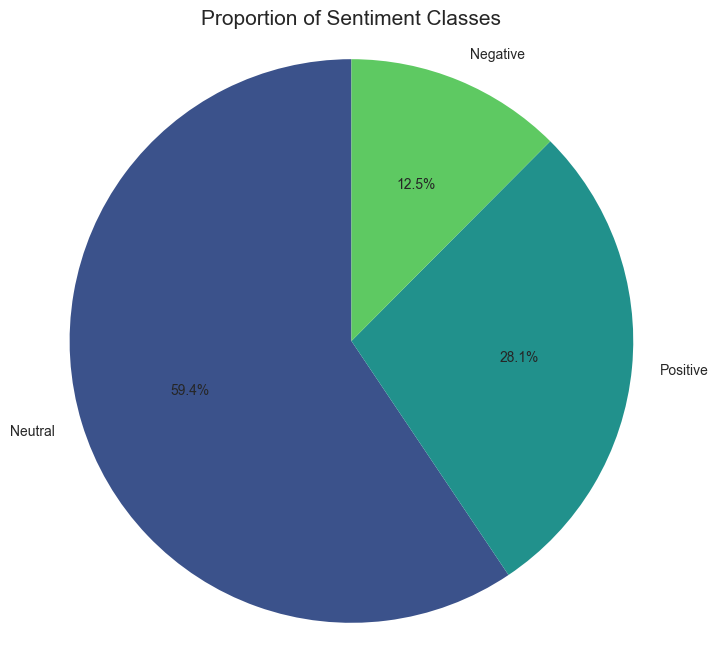

In [4]:
# Class mapping
class_mapping = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
}

# Count the sentiment classes
sentiment_counts = df['label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
sentiment_counts['Percentage'] = sentiment_counts['Count'] / sentiment_counts['Count'].sum() * 100

# Map numerical sentiment values to their text labels
sentiment_counts['Sentiment'] = sentiment_counts['Sentiment'].map(class_mapping)

# Display table of class distribution
print("Sentiment Class Distribution:")
display(sentiment_counts)

# Create a pie chart for a different perspective
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts['Count'], labels=sentiment_counts['Sentiment'], 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', 3))
plt.axis('equal')
plt.title('Proportion of Sentiment Classes', fontsize=15)
plt.show()


In [5]:
# Implement the class_mapping into the dataframe
df['label'] = df['label'].map(class_mapping)

### Token Count Analysis

Token Count Statistics:


,Input Text Tokens,Prompt Template Tokens,Input + Prompt Tokens,Output Tokens,Total Sequence Tokens
count,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,30.377000,181.834000,212.211000,2.0,214.211000
std,14.048567,0.520303,14.002448,0.0,14.002448
min,5.000000,180.000000,187.000000,2.0,189.000000
25%,20.000000,182.000000,202.000000,2.0,204.000000
50%,28.000000,182.000000,210.000000,2.0,212.000000
75%,38.000000,182.000000,220.000000,2.0,222.000000
max,94.000000,183.000000,276.000000,2.0,278.000000


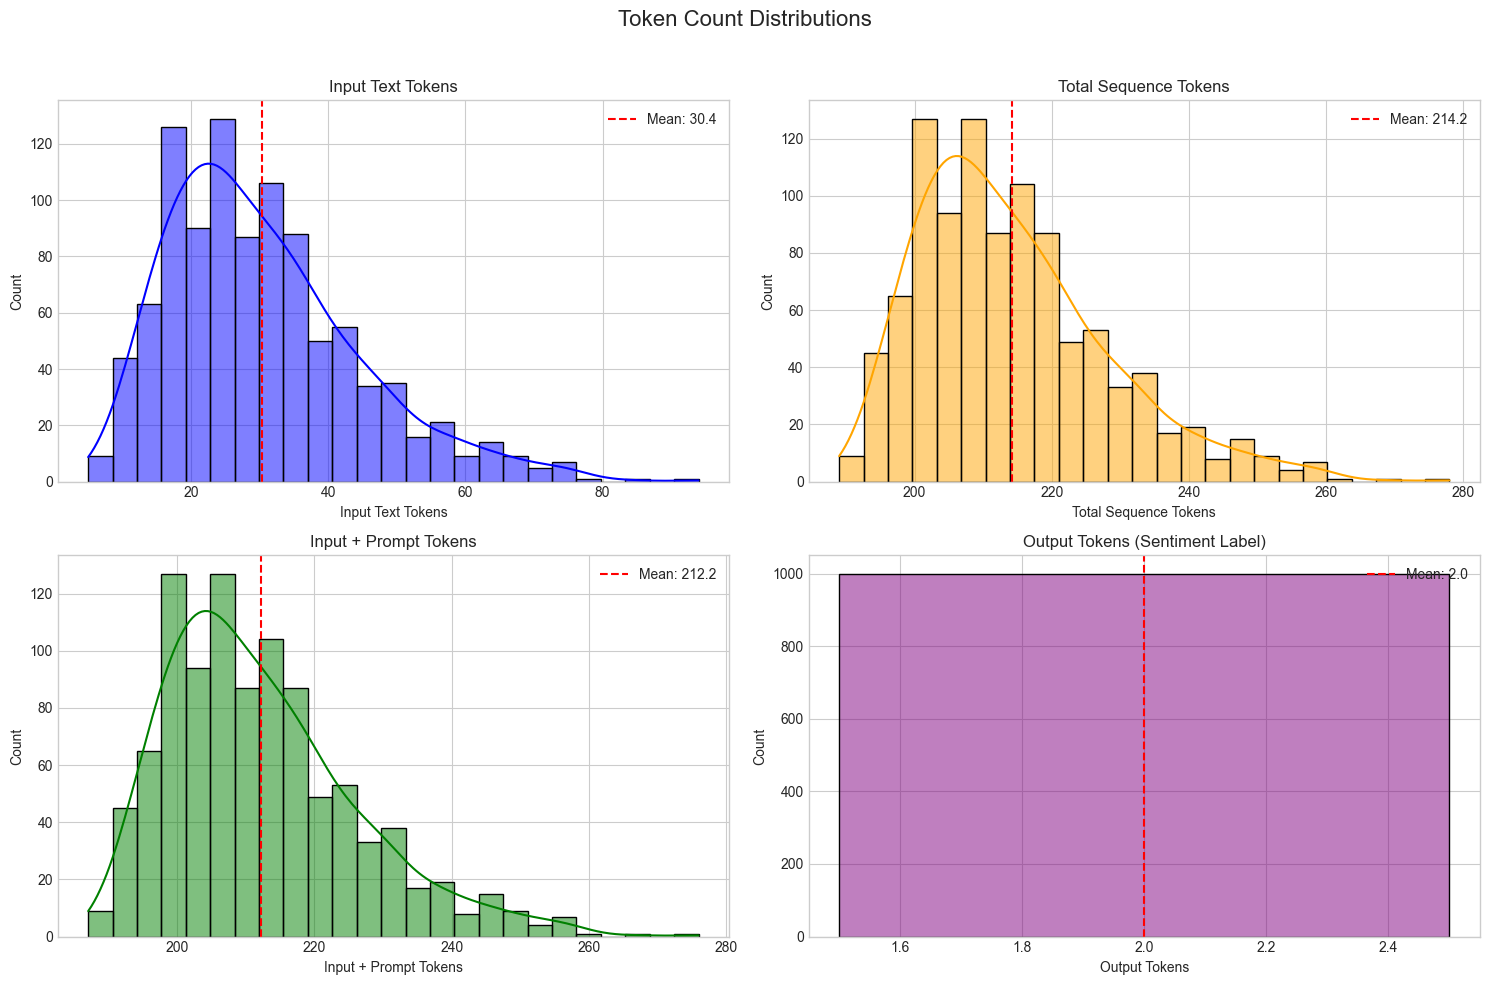

/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_70311/2604969847.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=token_df_melt, palette='viridis')


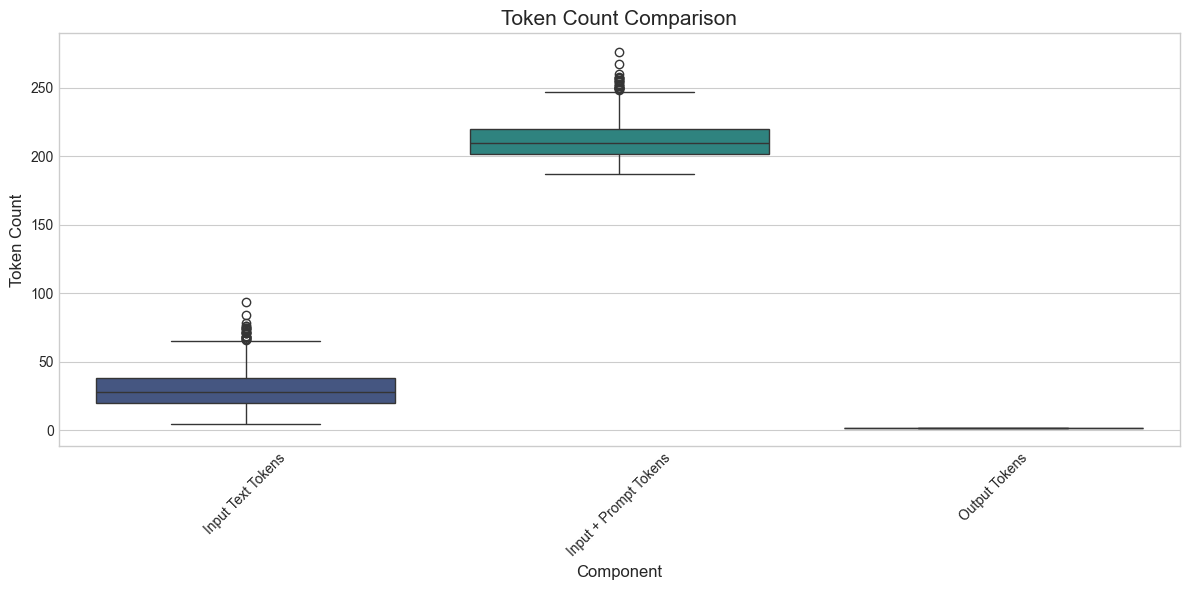


Number of examples exceeding 2048 token context window: 0


In [6]:
# Load the tokenizer (using the same one we'll use for our models)
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Change this to match your model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize lists to store token counts
input_token_counts = []
prompt_token_counts = []
output_token_counts = []
total_token_counts = []
prompt_template_tokens = []  # New: Store just the template size

# Sample size (use all if dataset is small, otherwise limit to a reasonable number)
sample_size = min(len(df), 1000)
sample_indices = np.random.choice(len(df), sample_size, replace=False)

# Calculate token counts for each example
for idx in sample_indices:
    # Original input text
    input_text = df.iloc[idx]['sentence']
    input_tokens = tokenizer.encode(input_text)
    input_token_counts.append(len(input_tokens))
    
    # Input text + prompt
    prompt_text = get_sentiment_prompt(input_text)
    prompt_tokens = tokenizer.encode(prompt_text)
    prompt_token_counts.append(len(prompt_tokens))
    
    # Just the prompt template (subtract input tokens)
    template_tokens = len(prompt_tokens) - len(input_tokens)
    prompt_template_tokens.append(template_tokens)
    
    # Output text (the sentiment label)
    output_text = df.iloc[idx]['label']
    output_tokens = tokenizer.encode(output_text)
    output_token_counts.append(len(output_tokens))
    
    # Total sequence length
    total_tokens = len(prompt_tokens) + len(output_tokens)
    total_token_counts.append(total_tokens)

# Create a DataFrame for the token counts
token_df = pd.DataFrame({
    'Input Text Tokens': input_token_counts,
    'Prompt Template Tokens': prompt_template_tokens,
    'Input + Prompt Tokens': prompt_token_counts,
    'Output Tokens': output_token_counts,
    'Total Sequence Tokens': total_token_counts
})

# Display token count statistics
print("Token Count Statistics:")
display(token_df.describe())

# Create visualizations for token counts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Token Count Distributions', fontsize=16)

# Input text tokens
sns.histplot(token_df['Input Text Tokens'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Input Text Tokens')
axes[0, 0].axvline(token_df['Input Text Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Input Text Tokens"].mean():.1f}')
axes[0, 0].legend()

# Input + Prompt tokens
sns.histplot(token_df['Input + Prompt Tokens'], kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Input + Prompt Tokens')
axes[1, 0].axvline(token_df['Input + Prompt Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Input + Prompt Tokens"].mean():.1f}')
axes[1, 0].legend()

# Output tokens
sns.histplot(token_df['Output Tokens'], kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Output Tokens (Sentiment Label)')
axes[1, 1].axvline(token_df['Output Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Output Tokens"].mean():.1f}')
axes[1, 1].legend()

# Total sequence tokens
sns.histplot(token_df['Total Sequence Tokens'], kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Total Sequence Tokens')
axes[0, 1].axvline(token_df['Total Sequence Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Total Sequence Tokens"].mean():.1f}')
axes[0, 1].legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a boxplot for token count comparison
plt.figure(figsize=(12, 6))
# Exclude total sequence tokens to make the scale more comparable
token_df_melt = pd.melt(token_df[['Input Text Tokens', 'Input + Prompt Tokens', 'Output Tokens']])
sns.boxplot(x='variable', y='value', data=token_df_melt, palette='viridis')
plt.title('Token Count Comparison', fontsize=15)
plt.xlabel('Component', fontsize=12)
plt.ylabel('Token Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check if any examples exceed a common context window size (e.g., 2048 tokens)
context_window = 2048
exceeding = token_df[token_df['Total Sequence Tokens'] > context_window]
print(f"\nNumber of examples exceeding {context_window} token context window: {len(exceeding)}")
if len(exceeding) > 0:
    print("Examples with longest token counts:")
    display(exceeding.sort_values('Total Sequence Tokens', ascending=False).head())